# Running `PESTPP-IES`

In this notebook we will use the pest interface that we constructed and tested in the previous notebooks to do prior and posterior parameter and forecast non-linear uncertainty analysis! exciting

In [1]:
import sys
import os
import shutil
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 
sys.path.append('../../dependencies/')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
font = {'size'   : 12}
mpl.rc('font', **font)
import flopy as fp
import pyemu


First let's make sure the previous steps have been completed

In [2]:
mname = "sgn_50"
t_d = os.path.join("..","..","models","template")
assert os.path.exists(t_d)

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"sgn.pst"))
assert pst.nobs != pst.nnz_obs

A critical first step in any predictive modeling analysis is a simple Monte Carlo analysis.  While simple in concept, this analysis provides incredible insights for many aspects of the modeling analysis, including clues about model stability (or otherwise), prior-data conflict, and, if the outputs of interest are included as "observations" in the control file (as they are in this case), then you also get Prior predictive uncertainty!

Mechanically, if you set `noptmax=-1`, this tell PESTPP-IES to evaluate the initial (e.g. prior) parameter ensemble and quit. easy as!

In [4]:
pst.control_data.noptmax = -1
pst.pestpp_options["save_binary"] = True
pst.write(os.path.join(t_d,"sgn.pst"),version=2)

noptmax:-1, npar_adj:69143, nnz_obs:43


Here we will use a pyemu helper function to start PESTPP-IES parallel mode so that we have a master instance and several workers.  The master coordinates the runs that need to be done and the workers just work....

In [5]:
worker_root = os.path.join("..","..","models")
pmc_m_d = os.path.join(worker_root,"master_prior_mc")
pyemu.os_utils.start_workers(t_d,"pestpp-ies","sgn.pst",num_workers=10,
                             master_dir=pmc_m_d,worker_root=worker_root,
                            port=4269)

Sweet!  Now we are in a position to plot the prior monte carlo results.  First, let's compare the simulated outputs to the observed values.  In this case, PESTPP-IES creates an "obs+noise" ensemble that, as the name suggests, is an observation ensemble of obseration values with unique, additive observation noise realizations (the observation standard deviation is taken as the inverse of the observation weight unless otherwise specified).  Conceptually, this means that the posterior PESTPP-IES result will account for both parameter and observation noise uncertainty!  

Below we will plot each obs+noise PDF with the corresponding simulated PDF

<Figure size 576x756 with 0 Axes>

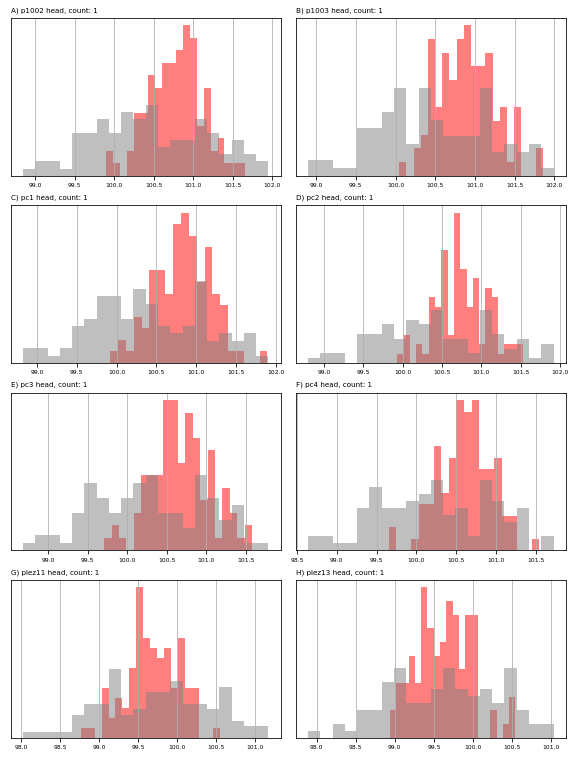

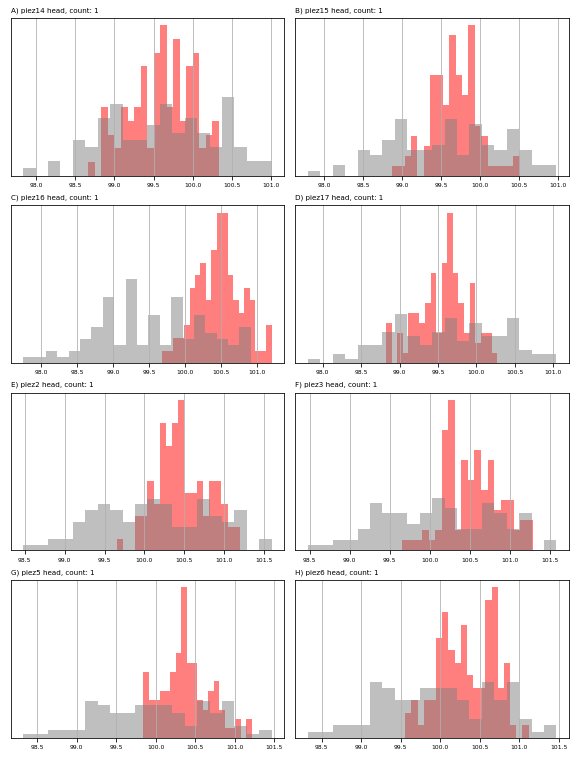

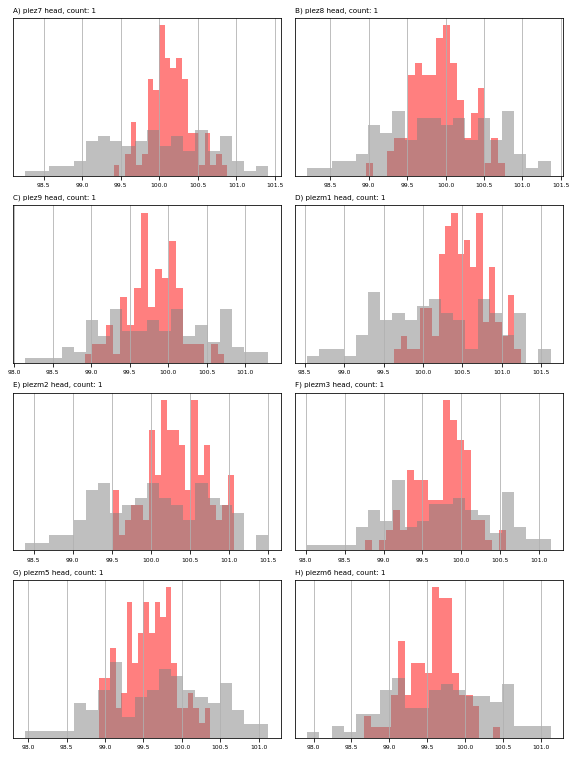

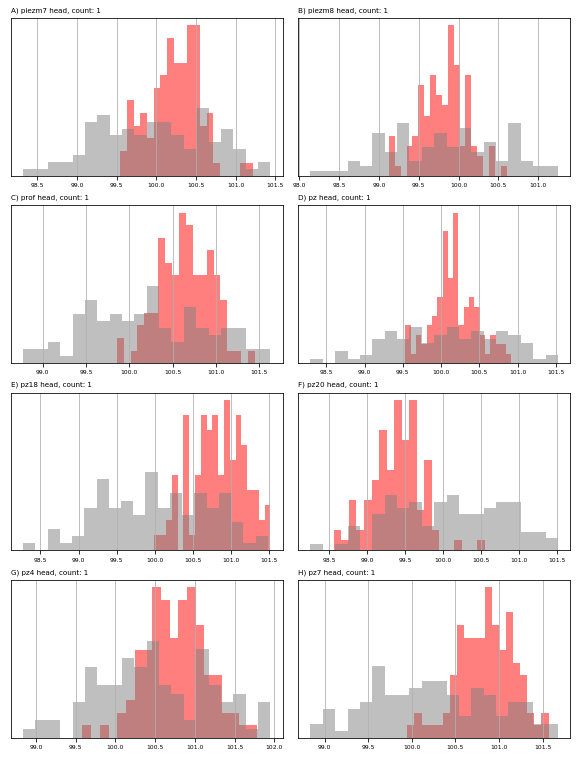

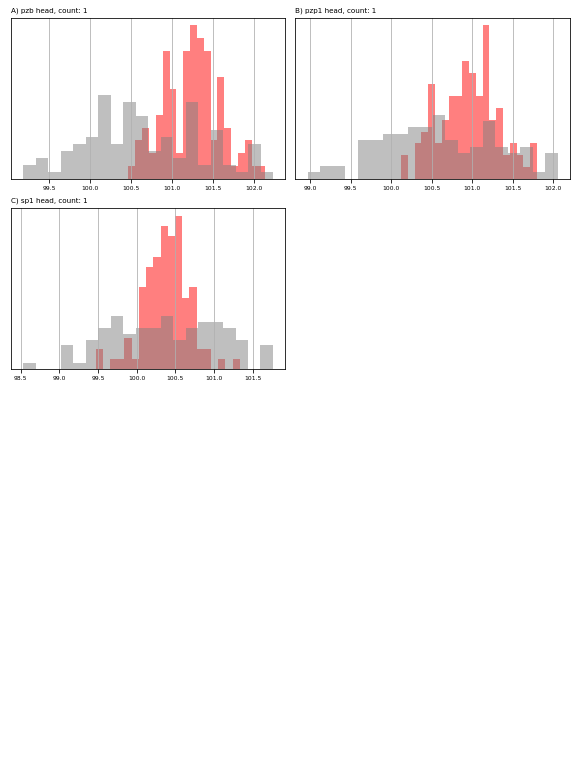

In [6]:
plot_cols = pst.observation_data.loc[pst.nnz_obs_names].apply(lambda x: x.usecol + " "+x.oname,axis=1).to_dict()
plot_cols = {v: [k] for k, v in plot_cols.items()}
obs_plus_noise = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(pmc_m_d,"sgn.obs+noise.jcb"))
pr_oe = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(pmc_m_d,"sgn.0.obs.jcb"))
pyemu.plot_utils.ensemble_helper({"r":obs_plus_noise,"0.5":pr_oe},
                                 plot_cols=plot_cols,bins=20,sync_bins=False,
                                func_dict={o:lambda x: np.log10(x) for o in pst.nnz_obs_names if "conc" in o},
                                density=True)
plt.show()

Any thoughts on these plots?  Any plot where the prior simulated PDF doesnt statistically cover the obs+noise PDF is a problem...

OK! Now we are ready for some (attempted) history matching.  Let's use 4 iterations

In [7]:
noptm = 4
pst.control_data.noptmax = noptm
pst.pestpp_options["ies_no_noise"] = False
pst.write(os.path.join(t_d,"sgn.pst"),version=2)
ies_m_d = os.path.join(worker_root,"master_ies")

noptmax:4, npar_adj:69143, nnz_obs:43


In [8]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","sgn.pst",num_workers=10,
                             master_dir=ies_m_d,worker_root=worker_root,port=4269)

Sweet!  Let's take a peek at the phi summary information from `pestpp-ies`

In [9]:
df = pd.read_csv(os.path.join(ies_m_d,"sgn.phi.actual.csv"))
df

,iteration,total_runs,mean,standard_deviation,min,max,0,1,2,3,...,90,91,92,93,94,95,96,97,98,base
0,0,100,249.0290,243.90900,34.3345,1419.9100,304.8000,62.7680,265.2220,1419.9100,...,78.0543,50.0065,66.5396,50.6875,352.7700,415.0060,59.3973,90.5011,98.0536,304.8000
1,1,232,26.2530,5.12426,16.7941,44.2413,27.7572,32.4560,19.7595,19.0575,...,20.1556,27.7940,29.7756,22.1970,23.4111,22.5441,26.4254,24.9196,31.5471,27.7105
2,2,364,22.2941,3.35650,16.5922,34.7497,21.1776,24.0346,22.7542,19.3171,...,18.3844,22.6250,24.1599,25.6715,18.4164,19.0232,18.5971,22.1732,31.9955,19.4518
3,3,496,21.2040,3.17546,16.2369,31.8671,19.6366,22.2728,23.8376,19.9224,...,17.8011,21.0162,21.8193,28.6726,16.8157,17.1666,16.7534,21.3289,31.8671,17.3578
4,4,628,20.8685,3.20615,15.8616,31.0269,18.7530,21.7345,24.7100,20.2962,...,17.7543,20.6455,20.7193,30.6596,16.1904,16.4312,16.1305,20.8388,31.0269,16.2427


Text(0.5, 0, 'model runs')

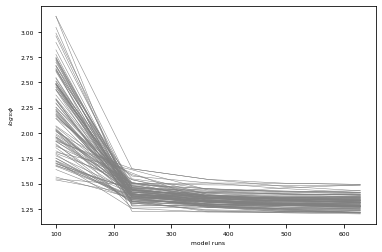

In [10]:
fig,ax = plt.subplots(1,1)
_ = [ax.plot(df.total_runs,np.log10(df.loc[:,i].values),"0.5",lw=0.5) for i in df.columns[5:]]
ax.set_ylabel("$log_{10}\\phi$")
ax.set_xlabel("model runs")

Now let's plot up the observations plus noise, the prior simulated values, and the posterior simulated values. first lets load up the prior and posterior observation ensembles

In [11]:
#pr_oe = pd.read_csv(os.path.join(ies_m_d,"sgn.0.obs.csv"),index_col=0)
#pt_oe = pd.read_csv(os.path.join(ies_m_d,"sgn.{0}.obs.csv".format(noptm)),index_col=0)

pr_oe = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(ies_m_d,"sgn.0.obs.jcb"))
pt_oe = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(ies_m_d,"sgn.{0}.obs.jcb".format(noptm)))
obs_plus_noise = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(ies_m_d,"sgn.obs+noise.jcb"))


<Figure size 576x756 with 0 Axes>

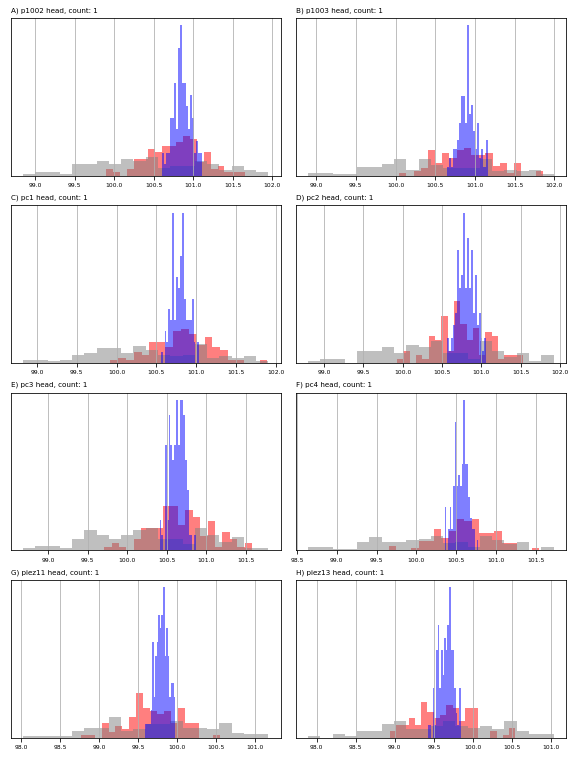

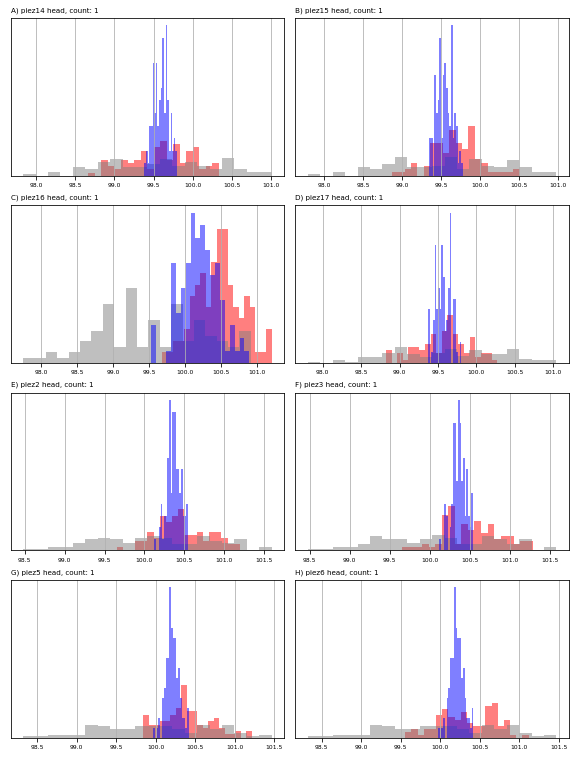

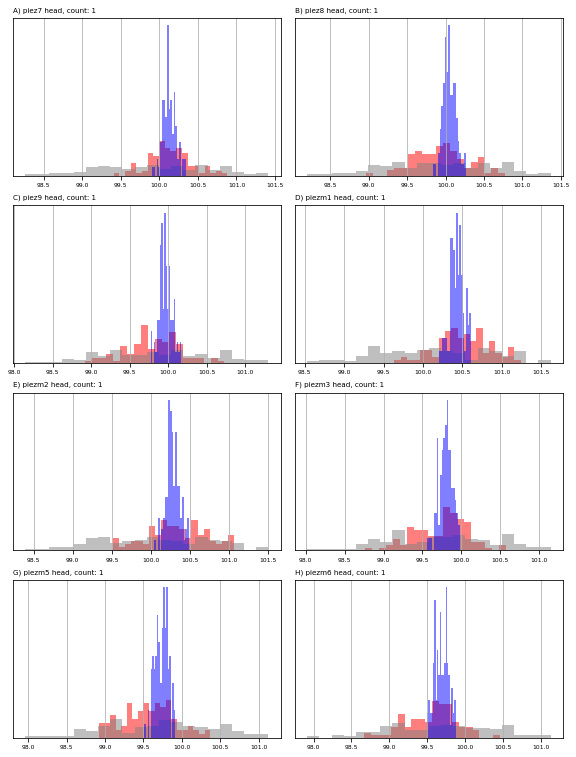

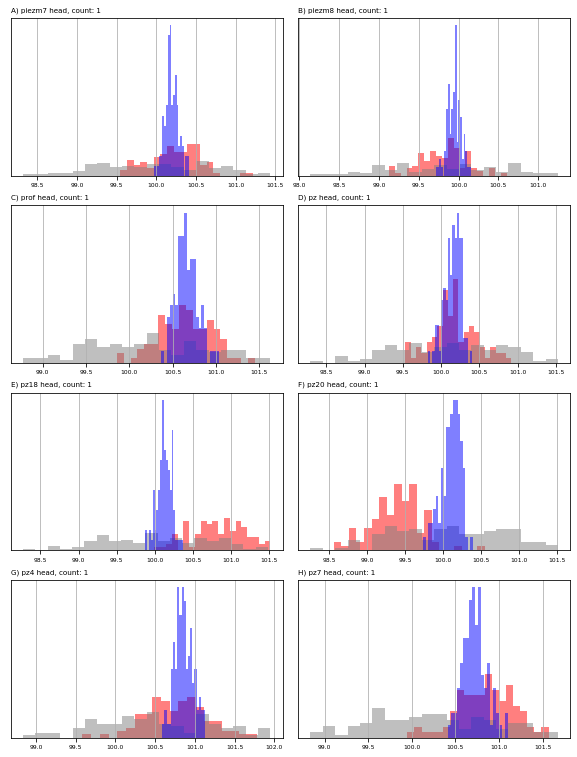

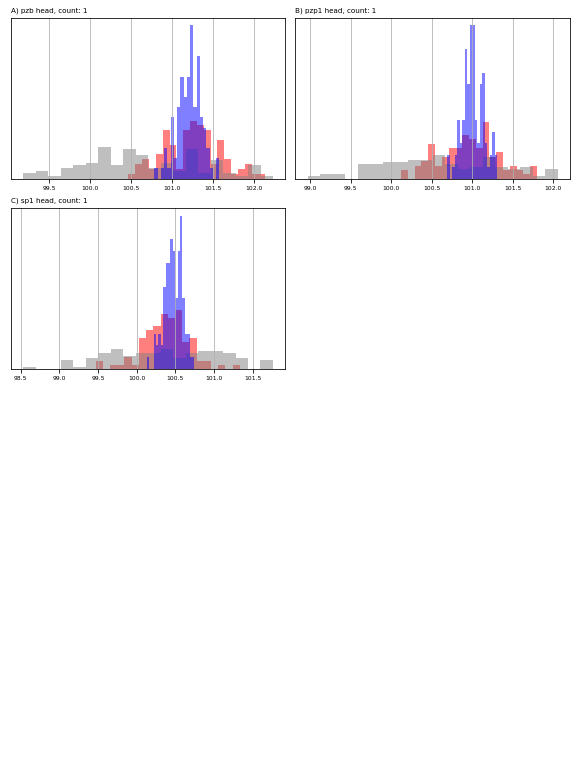

In [12]:
plot_cols = pst.observation_data.loc[pst.nnz_obs_names].apply(lambda x: x.usecol + " "+x.oname,axis=1).to_dict()
plot_cols = {v: [k] for k, v in plot_cols.items()}
pyemu.plot_utils.ensemble_helper({"r":obs_plus_noise,"0.5":pr_oe,"b":pt_oe},
                                  plot_cols=plot_cols,bins=20,sync_bins=False,
                                  func_dict={o:lambda x: np.log10(x) for o in pst.nnz_obs_names if "conc" in o})
plt.show()

Now lets plot up some head and concentration maps- always fun! Remember when we added observations for the simulated head and concentration in all model cells? here is where that pays off!  Here we will get pieces of the `pyemu.Pst.observation_data` dataframe that are for the layer head and concentrations of interest.  We can use `lay1_hds`/`lay1_ucn`, `lay2_hds`/`lay2_ucn` or `lay3_hds`/`lay3_ucn`

In [13]:
otag = "lay1"
otime = 1
obs = pst.observation_data
h_tag = "{0}__t{1}_hds".format(otag,otime)
c_tag = "{0}_t{1}_ucn".format(otag,otime)

print(h_tag,c_tag)

lay_hobs = obs.loc[obs.obsnme.str.contains(h_tag),:].copy()
assert lay_hobs.shape[0] > 0
lay_cobs = obs.loc[obs.obsnme.str.contains(c_tag),:].copy()
assert lay_cobs.shape[0] > 0
lay_hobs.loc[:,"i"] = lay_hobs.i.astype(int)
lay_cobs.loc[:,"i"] = lay_cobs.i.astype(int)
lay_hobs.loc[:,"j"] = lay_hobs.j.astype(int)
lay_cobs.loc[:,"j"] = lay_cobs.j.astype(int)

lay1__t1_hds lay1_t1_ucn


Let's just plot a few realizations

In [14]:
reals = pr_oe.index[:4].tolist()
reals.append("base")
reals

['0', '1', '2', '3', 'base']

Below, we just work out the min and max concentration and head values so that the plots are coherent

In [15]:
cmn = pt_oe.loc[reals,lay_cobs.obsnme].min().min()
cmx = pt_oe.loc[reals,lay_cobs.obsnme].max().max()
hmn = pt_oe.loc[reals,lay_hobs.obsnme].min().min()
hmx = pt_oe.loc[reals,lay_hobs.obsnme].max().max()
hlevels = np.linspace(hmn,hmx,4)

Now for some matplotlib hackery! For each realization, we will instantiate an empty numpy array and then fill it with the realization values. Then plot and add some nice things...

In [16]:
lay_hobs

,obsnme,obsval,weight,obgnme,oname,otype,usecol,time,i,j
obsnme,,,,,,,,,,
oname:lay1__t1_hds_otype:arr_i:0_j:0,oname:lay1__t1_hds_otype:arr_i:0_j:0,102.0519,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,0,0
oname:lay1__t1_hds_otype:arr_i:0_j:1,oname:lay1__t1_hds_otype:arr_i:0_j:1,102.0569,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,0,1
oname:lay1__t1_hds_otype:arr_i:0_j:10,oname:lay1__t1_hds_otype:arr_i:0_j:10,102.2145,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,0,10
oname:lay1__t1_hds_otype:arr_i:0_j:11,oname:lay1__t1_hds_otype:arr_i:0_j:11,102.2233,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,0,11
oname:lay1__t1_hds_otype:arr_i:0_j:12,oname:lay1__t1_hds_otype:arr_i:0_j:12,102.2320,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,0,12
...,...,...,...,...,...,...,...,...,...,...
oname:lay1__t1_hds_otype:arr_i:9_j:8,oname:lay1__t1_hds_otype:arr_i:9_j:8,101.8757,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,9,8
oname:lay1__t1_hds_otype:arr_i:9_j:80,oname:lay1__t1_hds_otype:arr_i:9_j:80,101.9812,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,9,80
oname:lay1__t1_hds_otype:arr_i:9_j:81,oname:lay1__t1_hds_otype:arr_i:9_j:81,101.9820,0.0,lay1__t1_hds,lay1,arr,NaN,NaN,9,81


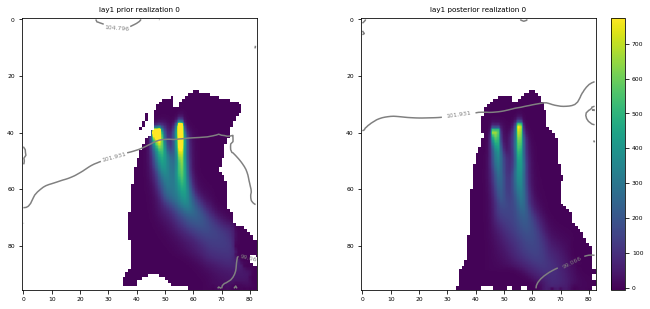

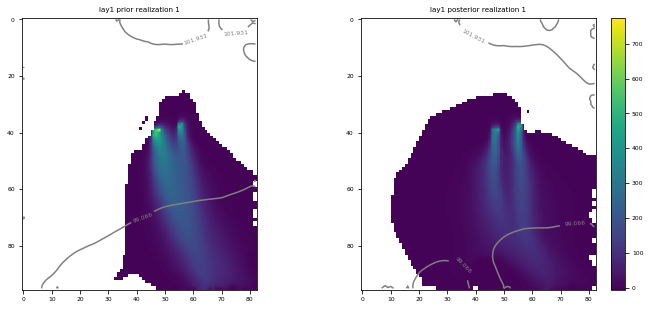

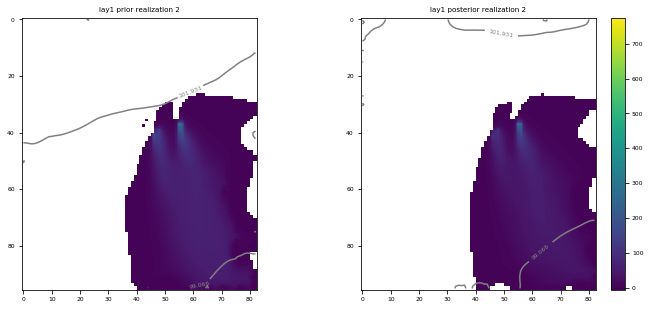

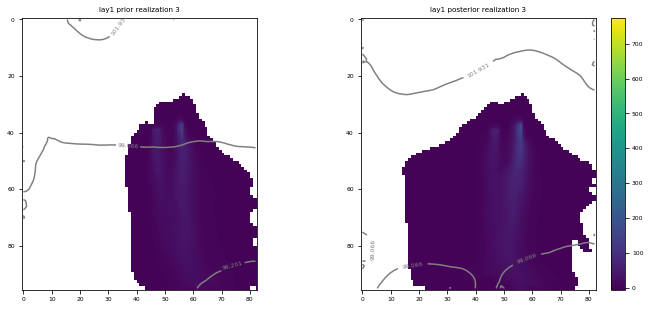

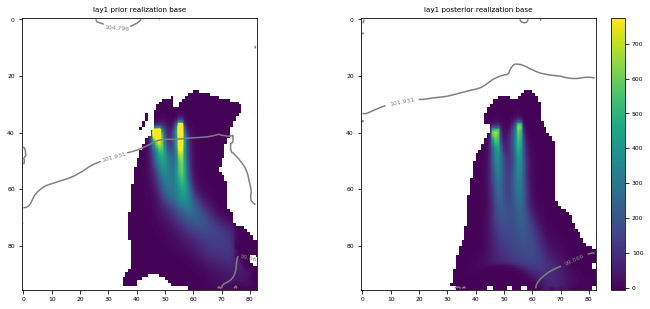

In [17]:
for real in reals:
    pr_harr = np.zeros((lay_hobs.i.max()+1,lay_hobs.j.max()+1))
    pr_harr[lay_hobs.i,lay_hobs.j] = pr_oe.loc[real,lay_hobs.obsnme]
    pr_carr = np.zeros((lay_cobs.i.max()+1,lay_cobs.j.max()+1))
    pr_carr[lay_cobs.i,lay_cobs.j] = pr_oe.loc[real,lay_cobs.obsnme]
    
    pt_harr = np.zeros((lay_hobs.i.max()+1,lay_hobs.j.max()+1))
    pt_harr[lay_hobs.i,lay_hobs.j] = pt_oe.loc[real,lay_hobs.obsnme]
    pt_carr = np.zeros((lay_cobs.i.max()+1,lay_cobs.j.max()+1))
    pt_carr[lay_cobs.i,lay_cobs.j] = pt_oe.loc[real,lay_cobs.obsnme]

    pr_carr[pr_carr<0.001] = np.nan
    pt_carr[pt_carr<0.001] = np.nan
    

    fig,axes = plt.subplots(1,2,figsize=(12,5))
    axes[0].imshow(pr_carr,vmin=cmn,vmax=cmx)
    cb = axes[1].imshow(pt_carr,vmin=cmn,vmax=cmx)
    plt.colorbar(cb,ax=axes[1])
    
    cs = axes[0].contour(pr_harr,levels=hlevels,colors="0.5")
    axes[0].clabel(cs)
    cs = axes[1].contour(pt_harr,levels=hlevels,colors="0.5")
    axes[1].clabel(cs)
    axes[0].set_title("{0} prior realization {1}".format(otag,real))
    axes[1].set_title("{0} posterior realization {1}".format(otag,real))
    
    
    plt.show()


For each realization, we see extreme concentration values in the prior, as we should since the prior represents expert knowledge only and no detailed aquifer-specific information that is contained in the observations.  But the posterior realizations are more tame after conditioning the parameters on those aquifer-specific data.

Now let's run PESTPP-IES again but this time without using concentration observations.  This will give us a measure of how important those concentration observations are for reducing predictive uncertainty...

In [18]:
conc_nnz_obs = [o for o in pst.nnz_obs_names if "conc" in o]
pst.observation_data.loc[conc_nnz_obs,"weight"] = 0
pst.write(os.path.join(t_d,"sgn.pst"),version=2)
ies_m_d_ho = os.path.join(worker_root,"master_ies_headonly")


noptmax:4, npar_adj:69143, nnz_obs:43


From here on, this is exactly the same code used above...

In [19]:
pyemu.os_utils.start_workers(t_d,"pestpp-ies","sgn.pst",num_workers=10,
                             master_dir=ies_m_d_ho,worker_root=worker_root,port=4269)

In [20]:
pr_oe_ho = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(ies_m_d_ho,"sgn.0.obs.jcb"))
pt_oe_ho = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(ies_m_d_ho,"sgn.{0}.obs.jcb".format(noptm)))
obs_plus_noise = pyemu.ObservationEnsemble.from_binary(pst=pst,filename=os.path.join(ies_m_d_ho,"sgn.obs+noise.jcb"))

reals_ho = pr_oe_ho.index[:4].tolist()
reals_ho.append("base")
reals_ho

['0', '1', '2', '3', 'base']

In [21]:
cmn = pt_oe_ho.loc[reals_ho,lay_cobs.obsnme].min().min()
cmx = pt_oe_ho.loc[reals_ho,lay_cobs.obsnme].max().max()
hmn = pt_oe_ho.loc[reals_ho,lay_hobs.obsnme].min().min()
hmx = pt_oe_ho.loc[reals_ho,lay_hobs.obsnme].max().max()
hlevels = np.linspace(hmn,hmx,4)

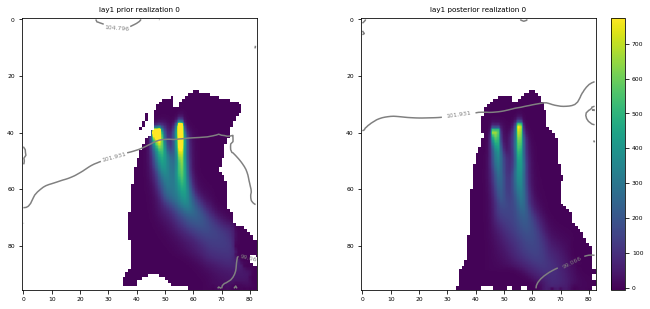

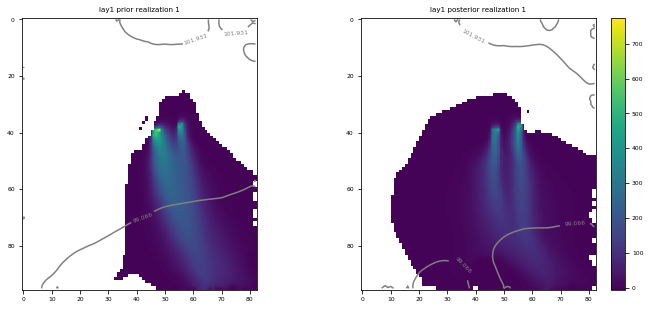

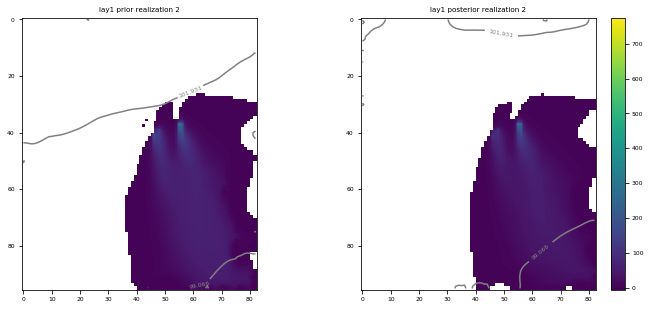

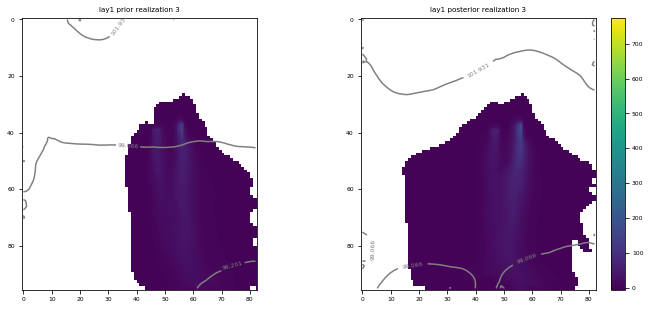

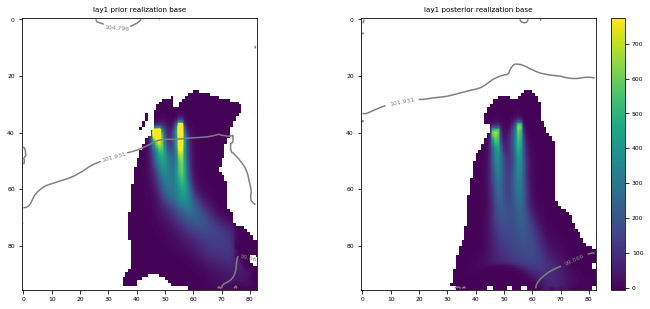

In [22]:
for real in reals_ho:
    pr_harr = np.zeros((lay_hobs.i.max()+1,lay_hobs.j.max()+1))
    pr_harr[lay_hobs.i,lay_hobs.j] = pr_oe_ho.loc[real,lay_hobs.obsnme]
    pr_carr = np.zeros((lay_cobs.i.max()+1,lay_cobs.j.max()+1))
    pr_carr[lay_cobs.i,lay_cobs.j] = pr_oe_ho.loc[real,lay_cobs.obsnme]
    
    pt_harr = np.zeros((lay_hobs.i.max()+1,lay_hobs.j.max()+1))
    pt_harr[lay_hobs.i,lay_hobs.j] = pt_oe_ho.loc[real,lay_hobs.obsnme]
    pt_carr = np.zeros((lay_cobs.i.max()+1,lay_cobs.j.max()+1))
    pt_carr[lay_cobs.i,lay_cobs.j] = pt_oe_ho.loc[real,lay_cobs.obsnme]

    pr_carr[pr_carr<0.001] = np.nan
    pt_carr[pt_carr<0.001] = np.nan
    

    fig,axes = plt.subplots(1,2,figsize=(12,5))
    axes[0].imshow(pr_carr,vmin=cmn,vmax=cmx)
    cb = axes[1].imshow(pt_carr,vmin=cmn,vmax=cmx)
    plt.colorbar(cb,ax=axes[1])
    
    cs = axes[0].contour(pr_harr,levels=hlevels,colors="0.5")
    axes[0].clabel(cs)
    cs = axes[1].contour(pt_harr,levels=hlevels,colors="0.5")
    axes[1].clabel(cs)
    axes[0].set_title("{0} prior realization {1}".format(otag,real))
    axes[1].set_title("{0} posterior realization {1}".format(otag,real))
    
    
    plt.show()